In [11]:
import pandas as pd
import numpy as np

In [117]:
#?pd.read_csv

# Read Daily Shareprices and Quarterlöy Income statements (Source SimFin)

In [1]:
# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [50]:
sf.set_data_dir('data/')

In [51]:
#sf.load_api_key(path='../../keys/simfin.key', default_key='free')
sf.set_api_key(api_key='free')

In [52]:
df = sf.load(dataset='income', variant='quarterly', market='us')

Dataset "us-income-quarterly" on disk (0 days old).
- Loading from disk ... Done!


In [54]:
stock = sf.load(dataset='shareprices', variant='daily', market='us')

Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!


# Re-read Files, Parse dates and cleanup column names

In [55]:
df = pd.read_csv("data/us-income-quarterly.csv",sep=';',header=0, parse_dates=[5,6,7])
stock = pd.read_csv("data/us-shareprices-daily.csv",sep=';',header=0, parse_dates=[2])
for s in [' ','.',',','(',')']:
    df.columns = df.columns.str.replace(s, '')
    stock.columns = stock.columns.str.replace(s, '')

In [13]:
symbol = 'MSFT'

In [14]:
msft = stock[stock.Ticker == symbol].set_index('Date')

In [15]:
df1 = df[df.Ticker == symbol].set_index('PublishDate')

In [16]:
df1['PublishDate'] = df1.index

In [17]:
df1.index.name = 'Date'

In [18]:
ms = msft.join(df1,how='left',rsuffix='inc').fillna(method='ffill')

In [19]:
ms.shape

(3223, 38)

In [20]:
ms = ms[~ms.Tickerinc.isnull()]

In [21]:
ms = ms.dropna(axis=1)

# Create Target to Predict

Target: Adjusted Close of Tomorrow

In [22]:
data = ms

In [23]:
tgt = 'AdjClose'
data[f"{tgt}_s1"] = ms[tgt].shift(-1)

data[f"spread"] = data[f"{tgt}_s1"] - data[tgt]
data[f"target"] = data[f"spread"] > 0

In [24]:
# Create Date/Timebased Features
data['weekday'] = data.index.weekday.astype(float)
data['dayofyear'] = data.index.dayofyear.astype(float)
data['month'] = data.index.month.astype(float)

In [25]:
# Create Hist. targes/values
for var in [f"spread",f"target"]:
    for lag in np.arange(1,10):
        data[f"{var}_lag{lag}"] = data[var].shift(lag)

for var in [f"target"]:
    for lag in np.arange(1,10):
        data[f"{var}_lag{lag}"] = data[var].shift(lag).astype(bool)        

In [26]:
data["Days_Since_Report"] = (data.index-data["PublishDate"]).apply(lambda x: x.days).astype(float)

In [27]:
data["Days_Since_Report"]

Date
2007-01-24     0.0
2007-01-25     1.0
2007-01-26     2.0
2007-01-29     5.0
2007-01-30     6.0
              ... 
2019-10-15    84.0
2019-10-16    85.0
2019-10-17    86.0
2019-10-18    87.0
2019-10-21    90.0
Name: Days_Since_Report, Length: 3209, dtype: float64

In [28]:
data = data.dropna()

In [29]:
data.to_parquet("msft.parq")

In [30]:
data['target_lag1']

Date
2007-02-06    False
2007-02-07    False
2007-02-08    False
2007-02-09    False
2007-02-12    False
              ...  
2019-10-14    False
2019-10-15     True
2019-10-16    False
2019-10-17    False
2019-10-18    False
Name: target_lag1, Length: 3199, dtype: bool

In [31]:
ms.columns

Index(['Ticker', 'SimFinId', 'Open', 'Low', 'High', 'Close', 'AdjClose',
       'Volume', 'Tickerinc', 'SimFinIdinc', 'Currency', 'FiscalYear',
       'FiscalPeriod', 'ReportDate', 'RestatedDate', 'SharesBasic',
       'SharesDiluted', 'Revenue', 'CostofRevenue', 'GrossProfit',
       'OperatingExpenses', 'SellingGeneral&Administrative',
       'Research&Development', 'OperatingIncomeLoss',
       'Non-OperatingIncomeLoss', 'PretaxIncomeLossAdj', 'PretaxIncomeLoss',
       'IncomeTaxExpenseBenefitNet', 'IncomeLossfromContinuingOperations',
       'NetIncome', 'NetIncomeCommon', 'PublishDate', 'AdjClose_s1', 'spread',
       'target', 'weekday', 'dayofyear', 'month', 'spread_lag1', 'spread_lag2',
       'spread_lag3', 'spread_lag4', 'spread_lag5', 'spread_lag6',
       'spread_lag7', 'spread_lag8', 'spread_lag9', 'target_lag1',
       'target_lag2', 'target_lag3', 'target_lag4', 'target_lag5',
       'target_lag6', 'target_lag7', 'target_lag8', 'target_lag9',
       'Days_Since_Report']

,Revenue,AdjClose
Revenue,1.000000,0.884823
AdjClose,0.884823,1.000000


<AxesSubplot:label='f051a302-8d5a-426d-8b7b-eb14d33f525f', xlabel='Date'>

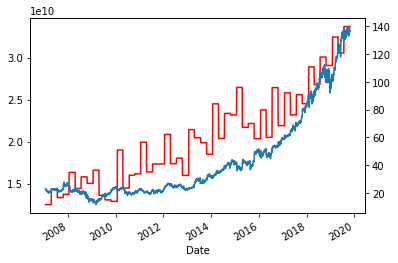

In [40]:
import matplotlib.pyplot as plt
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

display(ms[['Revenue','AdjClose']].corr())
ms['Revenue'].plot(ax=ax,color='red')
ms['AdjClose'].plot(ax=ax2)

,NetIncome,AdjClose
NetIncome,1.000000,0.430255
AdjClose,0.430255,1.000000


<AxesSubplot:label='3eb2992e-4dec-4af3-97c6-68512362544b', xlabel='Date'>

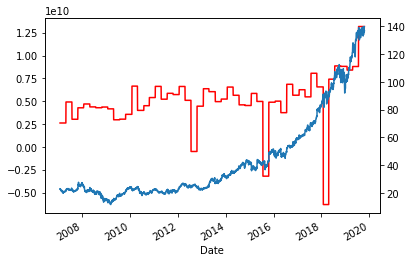

In [39]:
fig,ax = plt.subplots()
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

display(ms[['NetIncome','AdjClose']].corr())
ms['NetIncome'].plot(ax=ax,color='red')
ms['AdjClose'].plot(ax=ax2)